 3d-обработка изображений. Гомографии, сопоставление точек, изображений.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Трансформация QRcode ##

Функции

In [2]:
def prepared_bar_code(img, blur_level=(9, 9), kernel=cv.getStructuringElement(cv.MORPH_RECT, (4, 4)), 
                            erosion=2, dilation=2
                      ):
    plt.figure(figsize=(10, 6))
    
    ax1 = plt.subplot(231)    
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ax1.imshow(img, cmap = 'gray')
    ax1.set_title('Исходное изображение в серых тонах')
    
    
    # вычисление градиента (Scharr) в направлениях x и y
    ax2 = plt.subplot(232)
    gradX = cv.Sobel(img, ddepth = cv.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv.Sobel(img, ddepth = cv.CV_32F, dx = 0, dy = 1, ksize = -1)
    # вычитание градиентов
    gradient = cv.subtract(gradX, gradY)
    gradient = cv.convertScaleAbs(gradient)
    ax2.imshow(gradient);
    ax2.set_title('Изображение без градиентов')
    
    
    #размытие 
    ax3 = plt.subplot(233)
    blurred = cv.blur(gradient, blur_level)
    ax3.imshow(blurred)
    ax3.set_title('Изображение с размытием')


    #превращение в бинарное 
    ax4 = plt.subplot(234)
    ret, thresh = cv.threshold(blurred, 128, 255, cv.THRESH_BINARY)
    ax4.imshow(thresh)
    ax4.set_title('Бинарное изображение')


    #выделение элементов
    ax5 = plt.subplot(235)
    closed = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    ax5.imshow(closed);
    ax5.set_title('Элементы изображения')
    
    
    #удаление маленьких компонентов
    ax6 = plt.subplot(236)
    closed = cv.erode(closed, None, iterations = erosion)
    closed = cv.dilate(closed, None, iterations = dilation)
    ax6.imshow(closed);
    ax6.set_title('Без маленьких компонентов')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    return closed

In [3]:
def get_components(img):
    #отрисовка крайних точек компонент с нумерацией
    reval, labels, stats, centroids = cv.connectedComponentsWithStats(img)
    sort_stats = sorted(stats, key= lambda stat: stat[cv.CC_STAT_AREA], reverse = True)
    check_img = cv.cvtColor(img.copy(), cv.COLOR_BGR2RGB)
    
    for obj in range(len(sort_stats)):
        left, top, wight, height, area = sort_stats[obj]
        #точки
        cv.circle(check_img, (left,top), 7, (255, 0, 255), -1)
        cv.circle( check_img, (left+wight,top+height), 7, (255, 0, 255), -1);
        #номер компоненты
        cv.putText(check_img, f"{obj}", (left+5,top+5), cv.FONT_HERSHEY_COMPLEX, 2, (64, 224, 208), 1)
        
    plt.figure(figsize=(5,5))
    plt.imshow(check_img, cmap = 'gray')
    
    return sort_stats

In [4]:
def get_qrcode(stats, stats_index, img1, prep_img1, approx_index):

    fig, ax = plt.subplots( 1, 2, figsize = (7, 7))
    
    #обрезка изходного изображения по компоненте qrcode
    left, top, wight, height, area = stats[stats_index]
    qr_img = img1[top:top+height, left:left+wight]
    ax[0].imshow(qr_img)
    
    #отрисовка апроксимированных контуров
    check_img = cv.cvtColor(prep_img1[top:top+height, left:left+wight], cv.COLOR_BGR2RGB)
    (cnts, hierarchy) = cv.findContours(prep_img1[top:top+height, left:left+wight], cv.RETR_CCOMP, cv.CHAIN_APPROX_TC89_L1)

    aprox_obj = []
    for obj in range(len(hierarchy[0])):
            #if len(cnts[obj]) == 4:
            epsilon = 0.08 * cv.arcLength(cnts[obj], True)
            approximations = cv.approxPolyDP(cnts[obj], epsilon, True)
            cv.drawContours(check_img, [approximations], 0, (255, 69, 10), 3)
            
            aprox_obj += [approximations]
            
    ax[1].imshow(check_img)
    
    #возвращение точек контура qrcode
    c = sorted(aprox_obj, key = cv.contourArea, reverse = True)[approx_index].reshape(4, 2)
    return qr_img, c

In [5]:
def get_new_points(rectangle):
    #создание новых граничных точек
    (tl, bl, br, tr) = rectangle
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    if maxWidth < maxHeight:
        W = H = maxHeight
    else:
        H = W = maxWidth

    dst = np.float32(
        [[0, 0], [0, H], [W, H], [W, 0]])
    return dst, W, H

Загрузка изображений

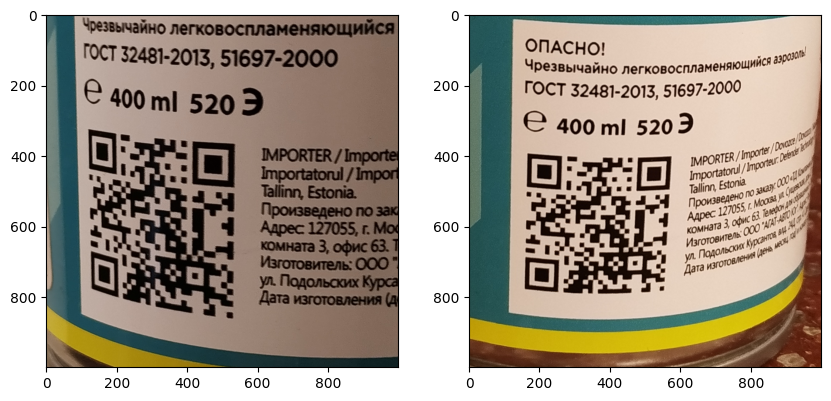

In [6]:
img1 = cv.imread('bottle0.jpg')[1500:2500,1000:2000,::-1]
img2 = cv.imread('bottle1.jpg')[1700:2700,700:1700,::-1]

fig, ax = plt.subplots( 1, 2, figsize = (10, 10))
ax[0].imshow(img1)
ax[1].imshow(img2)

## Первое изображение

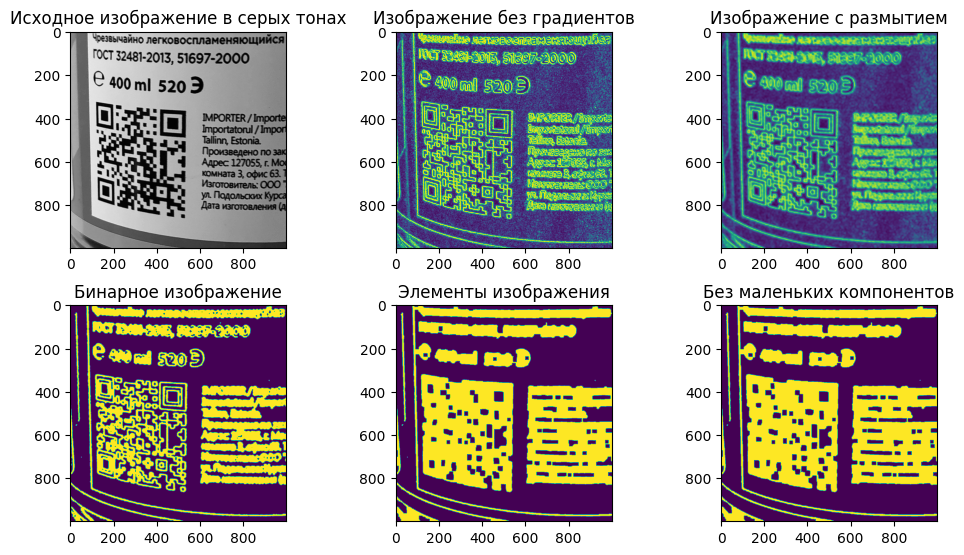

In [7]:
prepared_img1 = prepared_bar_code(img1, blur_level=(9, 9), kernel=cv.getStructuringElement(cv.MORPH_RECT, (15, 15)), 
                            erosion=1, dilation=1)

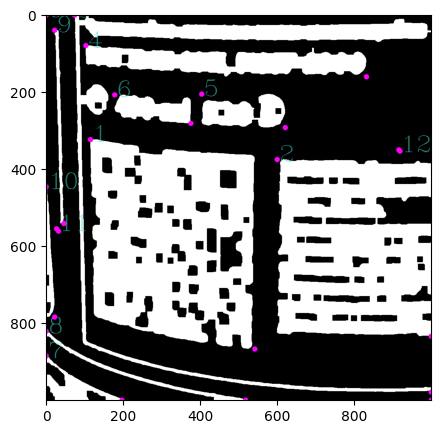

In [8]:
stats1 = get_components(prepared_img1)

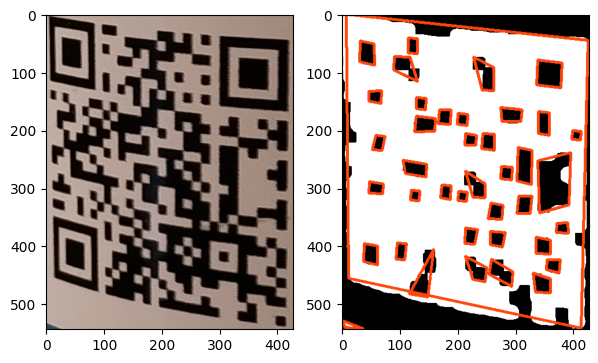

In [9]:
crop_img1, c1 = get_qrcode(stats1, 1, img1, prepared_img1, 0)

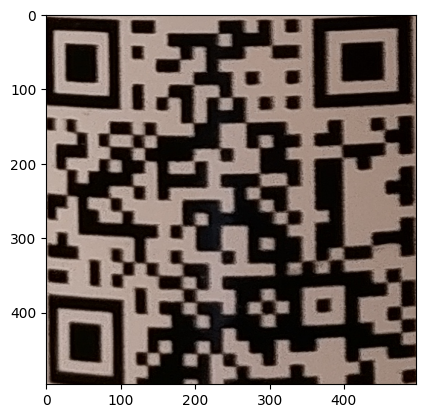

In [10]:
points1 = np.array(c1, dtype='float32')
new_points1, weight1, height1 = get_new_points(points1)
warp1 = cv.warpPerspective(crop_img1, cv.getPerspectiveTransform(points1, new_points1), (weight1, height1), flags=cv.INTER_LANCZOS4)
plt.imshow(warp1)

## Второе изображение

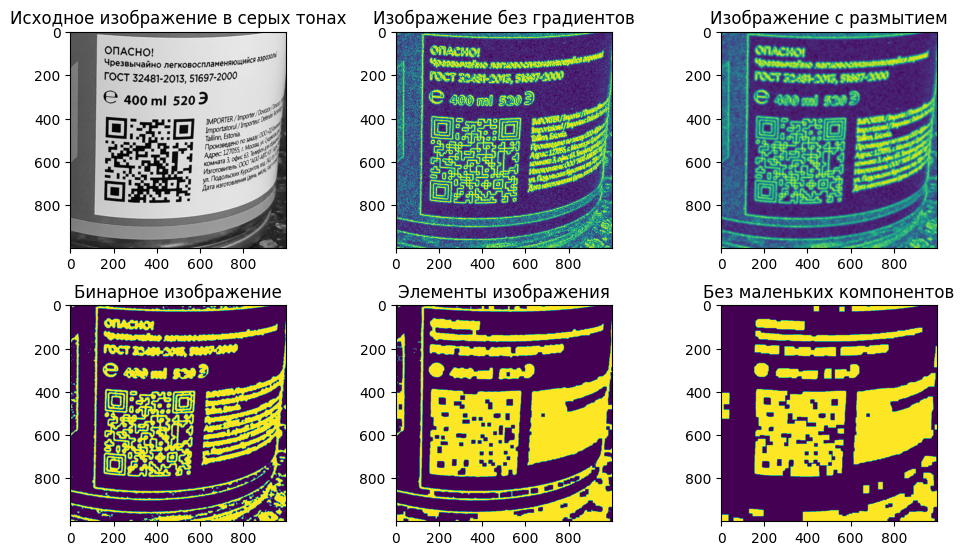

In [11]:
prepared_img2 = prepared_bar_code(img2, blur_level=(9, 9), kernel=cv.getStructuringElement(cv.MORPH_RECT, (15, 15)), 
                            erosion=10, dilation=10)

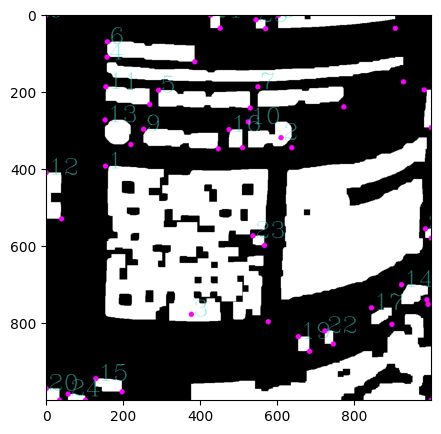

In [12]:
stats2 = get_components(prepared_img2)

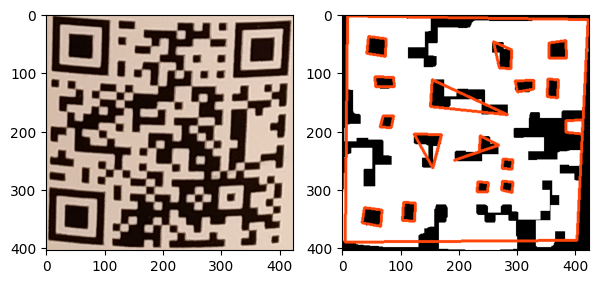

In [13]:
crop_img2, c2 = get_qrcode(stats2, 1, img2, prepared_img2, 0)

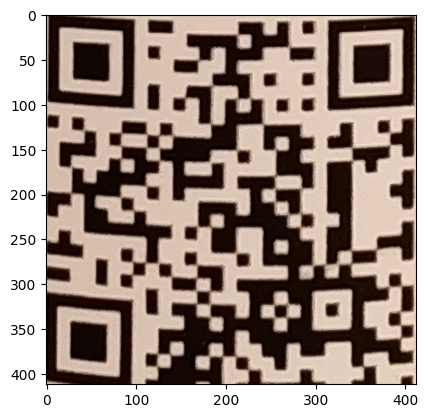

In [14]:
points2 = np.array(c2, dtype='float32')
new_points2, weight2, height2 = get_new_points(points2)
warp2 = cv.warpPerspective(crop_img2, cv.getPerspectiveTransform(points2, new_points2), (weight2, height2), flags=cv.INTER_LANCZOS4)
plt.imshow(warp2)